In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from time import time
from tqdm import tqdm
import os
from collections import defaultdict

import optuna

from sklearn.metrics import accuracy_score, recall_score


/home/james/virtual_envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from reserve import generate_reserve
from MDP_helpers import MDP, valueFunction, valueIteration, relabel_k
from kmdp_toolbox import aStarAbs, sk_to_s

In [3]:
from torch_geometric.data import Data
from torch.utils.data import DataLoader

# Training
from torch_geometric.nn.models import GCN
from torch.optim.lr_scheduler import ExponentialLR

In [4]:
from experiment import Experiment

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [6]:
# Generate Reserve Data
N_datasets = 100

N_sites = 4
N_species = 20
K = 6

N_states = 3**N_sites
N_actions = N_sites

print(f"Generating {N_datasets} MDPs with {N_states} states and {N_actions} actions \n")

mdp_datasets = []
for i in tqdm(range(N_datasets)):
    pj = np.random.random() # random probability between 0 and 1

    T, R = generate_reserve(N_sites, N_species, pj=pj, seed=i) 
    mdp = MDP(T, R, gamma=0.99)
    mdp.solve_MDP()

    mdp.k_states, mdp.K = aStarAbs(P=mdp.transitions, R=mdp.rewards, V=mdp.optimal_values, policy=mdp.optimal_policy, K=K, precision=1e-6)

    mdp_datasets.append(mdp)

Generating 100 MDPs with 81 states and 4 actions 



100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


In [7]:
dataset = []

for i in range(len(mdp_datasets)):
    # Set up data as graphs with node features defined by rewards and transition probabilities. Approach is to make dataset tabular as set node features
    P = mdp_datasets[i].transitions
    T = np.empty((N_states, N_states*N_actions))
    for i in range(27):
        T[i, :] = P[:, i, :].reshape(1, -1)

    x = np.concatenate([T, mdp_datasets[i].rewards], axis=1)

    # Cound whether transition are non-zero for any action
    p_sum = np.sum((P> 0), axis=0)
    edges = [[i, j] for i, j in zip(*np.where(p_sum > 0))]

    # Convert to torch
    x = torch.tensor(x, dtype=torch.float).to(device)
    edges = torch.tensor(edges, dtype=torch.int).T.to(device)

    k = torch.tensor(mdp_datasets[i].k_states, dtype=torch.int64).to(device)

    T = torch.tensor(mdp_datasets[i].transitions).to('cpu')
    R = torch.tensor(mdp_datasets[i].rewards).to('cpu')
    V = torch.tensor(mdp_datasets[i].optimal_values).to('cpu')

    dataset.append(
        Data(
            x=x,
            edges=edges,
            k_labels=k,
            T = T,
            R = R,
            V = V
        )
    )

In [8]:
def buildKMDP(T: torch.tensor, R: torch.tensor, predicted_k_states: torch.tensor, K: int) -> torch.tensor:
    """ Implement buildKMDP using inbuilt torch functions to keep everything on device """
    K2S = sk_to_s(predicted_k_states, K)
    weights = (1/torch.bincount(predicted_k_states))[predicted_k_states]

    RK = torch.empty(size=(K, N_actions), device=device, dtype=torch.float64)
    # R = torch.tensor(mdp.rewards).to(device)

    TK = torch.empty(size=(N_actions, K, K), device=device, dtype=torch.float64)
    # T = torch.tensor(mdp.transitions).to(device)

    for k in range(K):
        RK[k] = (R.T*weights).T[predicted_k_states==k].sum(axis=0)
        for kp in range(K):
            TK[:, k, kp] = (T[:, :, predicted_k_states==kp].sum(axis=2) * weights)[:, predicted_k_states==k].sum(axis=1)
    return TK, RK, K2S

In [9]:
# value iteration

def valueIteration(T: torch.tensor, R: torch.tensor, gamma = 0.99, epsilon=1e-4, N_iter=10000) -> torch.tensor:
    """ Implement Value Iteration in the pytorch environment """
    N_states, N_actions = R.shape
    V = torch.zeros(size=[N_states], device=device, dtype=torch.float64)
    Q = torch.empty(size=[N_states, N_actions], device=device, dtype=torch.float64)
    for i in range(N_iter):
        for a in range(N_actions):
            Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V

        V_new, policy = Q.max(axis=1)

        if torch.all(torch.abs(V_new - V) < epsilon):
            break
        
        if i == N_iter - 1:
            raise Exception("Did not converge in time. Consider increasing the number of iterations.")

        V = V_new
    return V_new, policy

In [10]:
def valueFunction(T, R, policy, gamma=0.99, epsilon=1e-3, N_iter = 1e6):
    """ Calculate the value function of an mdp given a policy """
    N_states, N_actions = R.shape
    
    V = torch.zeros(size=[N_states])
    V_new = torch.zeros(size=[N_states])

    count = 0
    converged=False
    while not converged:
        for s in range(N_states):
            V_new[s] = R[s, policy[s]] + gamma*(T[policy[s], s]*V).sum()

        if torch.max(V_new - V) < epsilon:
            converged = True

        V = 1*V_new

        count += 1
        if count >= N_iter:
            print("Did not converge")
            break
        
    return V_new

In [11]:
def calculate_gap(T, R, V, predicted_k_states, K):
    # predicted_k_states = #F.softmax(prediction, dim=1).argmax(axis=1)

    new_K = len(predicted_k_states.unique())
    predicted_k_states = relabel_k(predicted_k_states, K) if new_K != K else predicted_k_states

    PK, RK, K2S = buildKMDP(T, R, predicted_k_states, new_K)
    _, kmdp_policy = valueIteration(PK, RK, gamma=0.85, N_iter=50000, epsilon=1e-1)

    k_policy = torch.empty(size=[N_states], dtype=torch.int64)

    for k in range(new_K):
        k_policy[K2S[k]] = kmdp_policy[k]

    V_K = valueFunction(T, R, k_policy)

    gap = torch.max(torch.abs(V - V_K))
    error = gap/max(V)

    return gap, error


In [12]:
# ChatGPT written
def multiclass_recall_score(y_true, y_pred, average='macro'):
    """
    Calculate the multiclass recall score using PyTorch.

    Parameters:
    - y_true (torch.Tensor): True labels (ground truth).
    - y_pred (torch.Tensor): Predicted labels.
    - average (str): Type of averaging to use for multiclass recall.
        - 'macro' (default): Calculate recall for each class and then take the average.
        - 'micro': Calculate recall globally by considering all instances.
        - 'weighted': Calculate recall for each class and weight them by support.

    Returns:
    - recall (float): The multiclass recall score.
    """
    assert len(y_true) == len(y_pred), "Input arrays must have the same length"

    if average not in ('macro', 'micro', 'weighted'):
        raise ValueError("Invalid 'average' parameter. Use 'macro', 'micro', or 'weighted'.")

    num_classes = len(torch.unique(y_true))
    recall_per_class = []

    for class_label in range(num_classes):
        true_positive = torch.sum((y_true == class_label) & (y_pred == class_label)).item()
        false_negative = torch.sum((y_true == class_label) & (y_pred != class_label)).item()
        recall = true_positive / (true_positive + false_negative + 1e-10)  # Adding a small epsilon to avoid division by zero
        recall_per_class.append(recall)

    if average == 'macro':
        return sum(recall_per_class) / num_classes
    elif average == 'micro':
        total_true_positives = torch.sum((y_true == y_pred) & (y_true == class_label)).item()
        total_false_negatives = torch.sum((y_true != y_pred) & (y_true == class_label)).item()
        return total_true_positives / (total_true_positives + total_false_negatives + 1e-10)
    elif average == 'weighted':
        class_counts = [torch.sum(y_true == class_label).item() for class_label in range(num_classes)]
        total_samples = len(y_true)
        weights = [count / total_samples for count in class_counts]
        weighted_recall = sum([recall_per_class[i] * weights[i] for i in range(num_classes)])
        return weighted_recall

In [13]:
hparams = Experiment('hparams').load()
hparams = pd.DataFrame(hparams).sort_values(by='score')

In [14]:
hparams

,score,hidden_channels,num_layers,dropout,lr,weight_decay,gamma
13,0.300534,176.0,1.0,0.004101,2.698927,0.001483,0.997018
23,0.300578,181.0,1.0,0.011083,1.437395,0.001152,0.993384
21,0.330314,200.0,1.0,0.010138,1.470617,0.012731,0.995448
19,0.335703,199.0,1.0,0.023975,2.237262,0.001150,0.969591
16,0.341265,198.0,1.0,0.000221,0.233100,0.022892,0.994612
28,0.342057,149.0,1.0,0.007412,0.905140,0.020630,0.996630
14,0.394558,124.0,1.0,0.004573,1.926734,0.042765,0.984233
29,0.933195,184.0,1.0,0.016503,2.584442,0.013937,0.915158
22,1.006778,200.0,1.0,0.026455,2.012364,0.011800,0.923395
24,1.062955,178.0,1.0,0.010932,1.298478,0.013479,0.888989


{'score': 0.4358570534022619,
 'hidden_channels': 177.0,
 'num_layers': 1.0,
 'dropout': 0.09264598970849014,
 'lr': 1.0825370546000228,
 'weight_decay': 0.08971584798256982,
 'gamma': 0.9900683399893949,
 'weight_param': 10.0}

In [15]:
best_params = hparams.iloc[0]

In [16]:
from time import time

In [17]:
all_results = defaultdict(lambda : defaultdict(list))
N_epochs = 300

times = defaultdict(float)

for trial_num in range(10):
    trial_name = f"trial_{trial_num}"
    torch.cuda.manual_seed(trial_num)
    np.random.seed(trial_num)

    np.random.shuffle(dataset)
    data_split = int(len(dataset)*0.8)
    train_data = dataset[:data_split]
    test_data = dataset[data_split:]

    gcn_model = GCN(
        in_channels=int(dataset[0].x.shape[1]), 
        out_channels=K, 
        hidden_channels=int(best_params['hidden_channels']), 
        num_layers=int(best_params['num_layers']), 
        dropout=best_params['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(gcn_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])


    loss_function = torch.nn.CrossEntropyLoss()
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=best_params['gamma'])

    epochs = tqdm(range(N_epochs))
    total_time = 0
    for epoch in epochs:
        t1 = time()
        gcn_model.train()
        optimizer.zero_grad()

        total_loss = 0

        for data in train_data:
            pred = gcn_model(
                x=data.x,
                edge_index=data.edges
            )

            total_loss += loss_function(pred, data.k_labels)

        total_loss /= len(train_data)
        total_loss.backward()
        optimizer.step()
        lr_sheduler.step()

        total_time += time() - t1
        
        all_results[trial_name]['training_loss'].append(total_loss.to('cpu').detach().float())

        gcn_model.eval()
        total_gap = 0
        total_error = 0
        total_loss = 0
        for data in test_data:
            pred = gcn_model(
                x=data.x,
                edge_index=data.edges
            )

            total_loss += loss_function(pred, data.k_labels)

            pred_k = F.softmax(pred, dim=1).argmax(axis=1).to('cpu')
            gap, error = calculate_gap(data.T, data.R, data.V, pred_k, K)
            total_gap += gap
            total_error += error

        total_gap /= len(train_data)
        total_error/=len(test_data)

        total_loss /= len(test_data)

        all_results[trial_name]['test_loss'].append(total_loss.to('cpu').detach().float())
        all_results[trial_name]['testing_gap'].append(total_gap.to('cpu').detach().float())
        all_results[trial_name]['testing_error'].append(total_error.to('cpu').detach().float())
        epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {total_loss:.4f}, Gap {total_gap:.4f}")
        
    times[trial_name] = total_time

  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_73633/1842571840.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
Trial 9, Epoch 300/300, Loss 0.5432, Gap 0.0374: 100%|██████████| 300/300 [02:11<00:00,  2.29it/s]


In [18]:
os.mkdir(f"multi_run_{N_states}_states_10_runs")

In [19]:
times = pd.Series(times)

times.to_csv(f"multi_run_{N_states}_states_10_runs/times.csv")

In [20]:
training_loss = pd.DataFrame({trial_id:all_results[trial_id]['training_loss'] for trial_id in all_results.keys()}).astype(float)
test_loss = pd.DataFrame({trial_id:all_results[trial_id]['test_loss'] for trial_id in all_results.keys()}).astype(float)
test_gap = pd.DataFrame({trial_id:all_results[trial_id]['testing_gap'] for trial_id in all_results.keys()}).astype(float)
test_error = pd.DataFrame({trial_id:all_results[trial_id]['testing_error'] for trial_id in all_results.keys()}).astype(float)

In [21]:
training_loss.to_csv(f"multi_run_{N_states}_states_10_runs/training_loss.csv")
test_loss.to_csv(f"multi_run_{N_states}_states_10_runs/test_loss.csv")
test_gap.to_csv(f"multi_run_{N_states}_states_10_runs/test_gap.csv")
test_error.to_csv(f"multi_run_{N_states}_states_10_runs/test_error.csv")

In [22]:
true_gap = []
true_error = []

for i in range(len(mdp_datasets)):
    T = torch.tensor(mdp_datasets[i].transitions).to('cpu')
    R = torch.tensor(mdp_datasets[i].rewards).to('cpu')
    V = torch.tensor(mdp_datasets[i].optimal_values).to('cpu')
    k_states = torch.tensor(mdp_datasets[i].k_states, dtype=torch.int64)
    gap, error = calculate_gap(T, R, V, k_states, K)
    true_gap.append(gap)
    true_error.append(error)

In [28]:
np.mean(true_error)

0.01398800051102462

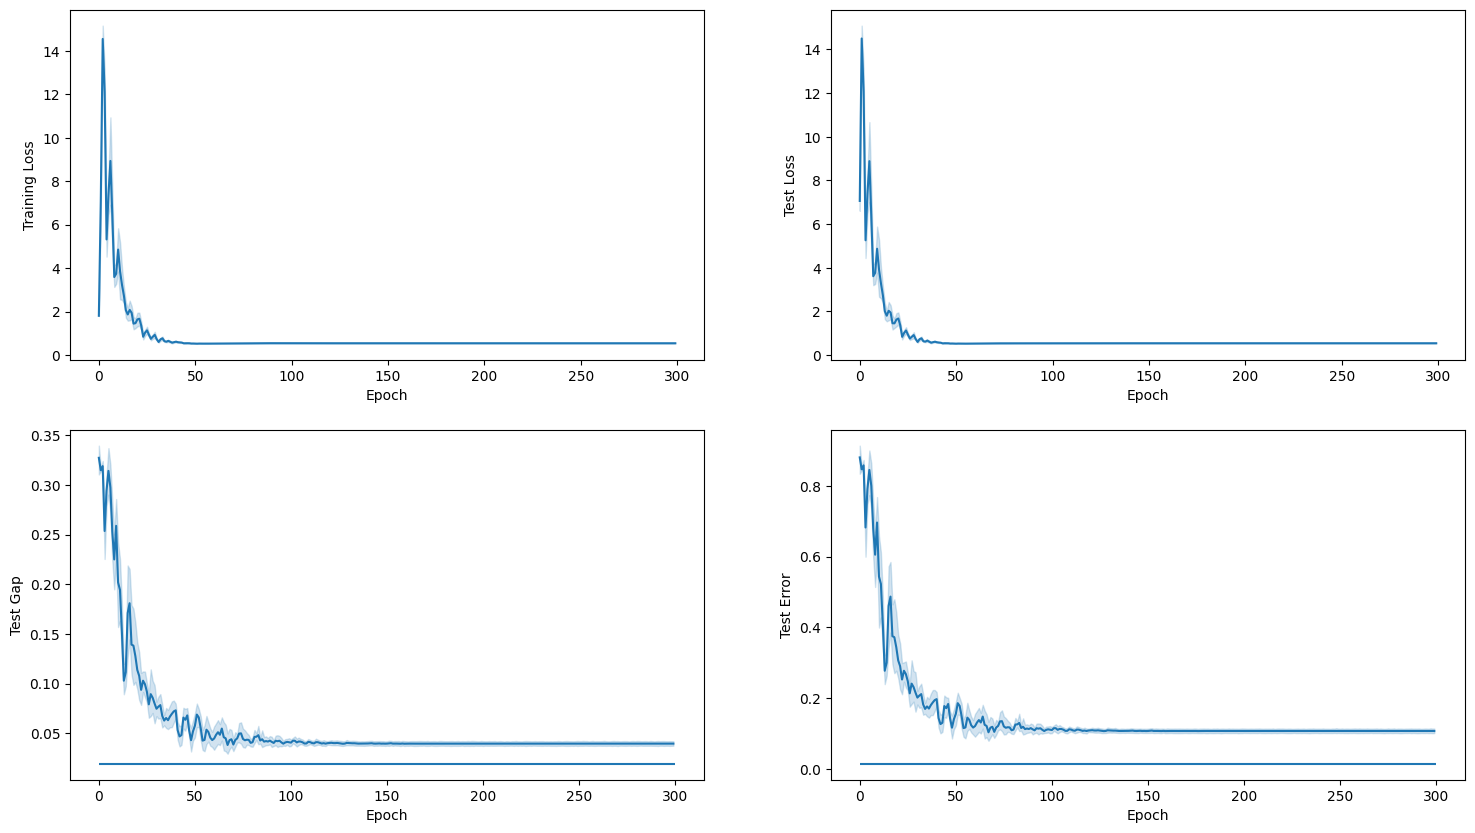

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))

training_loss_long = training_loss.stack()
training_loss_long.index = training_loss_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(training_loss_long, errorbar='ci', ax=ax[0, 0])
ax[0, 0].set_ylabel("Training Loss")
ax[0, 0].set_xlabel("Epoch")

test_loss_long = test_loss.stack()
test_loss_long.index = test_loss_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_loss_long, errorbar='ci', ax=ax[0, 1])
ax[0, 1].set_ylabel("Test Loss")
ax[0, 1].set_xlabel("Epoch")


test_gap_long = test_gap.stack()
test_gap_long.index = test_gap_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_gap_long, errorbar='ci', ax=ax[1, 0])
ax[1, 0].set_ylabel("Test Gap")
ax[1, 0].set_xlabel("Epoch")

ax[1, 0].hlines(np.mean(true_gap), 0, 300)

test_error_long = test_error.stack()
test_error_long.index = test_error_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_error_long, errorbar='ci', ax=ax[1, 1])
ax[1, 1].set_ylabel("Test Error")
ax[1, 1].set_xlabel("Epoch")
ax[1, 1].hlines(np.mean(true_error), 0, 300)

plt.savefig(f"multi_run_{N_states}_states_10_runs/results.png")

In [24]:
test_error

,trial_0,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9
0,0.859295,0.932915,0.939866,0.934309,0.882558,0.894415,0.711647,0.925257,0.874768,0.846078
1,0.842646,0.842646,0.842646,0.842646,0.842646,0.842646,0.842646,0.842646,0.842646,0.879029
2,0.842646,0.842646,0.842646,0.880549,0.852537,0.906276,0.842646,0.842646,0.879259,0.844424
3,0.383395,0.749864,0.735759,0.678857,0.743597,0.615254,0.678079,0.678120,0.714907,0.842646
4,0.875521,0.678800,0.788816,0.732193,0.798817,0.730386,0.868827,0.878829,0.741091,0.816664
...,...,...,...,...,...,...,...,...,...,...
295,0.097627,0.129111,0.110022,0.103392,0.113000,0.117900,0.103616,0.093848,0.098652,0.100702
296,0.097627,0.129111,0.110022,0.103392,0.113000,0.117900,0.103616,0.093848,0.098652,0.100702
297,0.097627,0.129111,0.110022,0.103392,0.113000,0.117900,0.103616,0.093848,0.098652,0.100702
298,0.097627,0.129111,0.110022,0.103392,0.113000,0.117900,0.103616,0.093848,0.098652,0.100702


In [25]:
times

trial_0    24.567788
trial_1    23.133244
trial_2    24.279062
trial_3    23.738456
trial_4    24.054693
trial_5    23.970008
trial_6    22.291575
trial_7    20.274222
trial_8    20.139767
trial_9    20.231584
dtype: float64